In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(5*1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.14:43440' processes=5 threads=35, memory=600.00 GB>

## 1. Read AVISO data

In [5]:
# .nc data downloaded from the AVISO center (2 years, daily, num. 731)
AVISO_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/AVISO/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

filenames = sorted(glob(AVISO_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

Number of files processed: 731


In [6]:
aviso_nc = Dataset(filenames[0],'r')  
aviso_nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    cdm_data_type: Grid
    title: DT merged Global Ocean Gridded Absolute Geostrophic Velocities SSALTO/Duacs L4 product
    summary: This dataset contains Delayed Time Level-4 absolute geostrophic velocities products from multi-satellite observations over Global Ocean.
    comment: Surface product; Absolute Geostrophic Velocities
    time_coverage_resolution: P1D
    product_version: 5.0
    institution: CNES, CLS
    project: SSALTO/DUACS
    references: www.aviso.altimetry.fr
    contact: aviso@altimetry.fr
    license: http://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf
    platform: Cryosat-2, Envisat Extension Phase, Jason-1 New Orbit, Jason-2
    date_created: 2014-02-28 17:45:17
    history: 2014-02-28 17:45:17:creation
    Conventions: CF-1.6
    standard_name_vocabulary: http://cf-pcmdi.llnl.gov/documents/cf-standard-names/standard-name-table/12/cf-standard-n

In [17]:
time = aviso_nc.variables['time'][:]
time = np.array(time)
u = aviso_nc.variables['u'][:]
u = np.array(u)
v = aviso_nc.variables['v'][:]
v = np.array(v)
ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time,'lati':(('lat','lon'),yv),'loni':(('lat','lon'),xv)})
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 1)
Coordinates:
  * time     (time) float32 22645.0
    lati     (lat, lon) float32 -89.875 -89.875 -89.875 ... 89.875 89.875 89.875
    loni     (lat, lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
Dimensions without coordinates: lat, lon
Data variables:
    u        (time, lat, lon) float64 -2.147e+09 -2.147e+09 ... -2.147e+09
    v        (time, lat, lon) float64 -2.147e+09 -2.147e+09 ... -2.147e+09

In [ ]:
# divergence
fig = plt.figure(figsize=(36,18))
(du_dx_ij+dv_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.00001,vmax=0.00001,cmap=cm.balance)

In [9]:
filenames = sorted(glob(AVISO_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):

    #
    file_out = out_dir_nc+'/madt_uv_t%03d.nc'%(i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        aviso_nc = Dataset(filenames[i],'r')         
        lat = aviso_nc.variables['lat'][:]
        lat = np.array(lat)
        lon = aviso_nc.variables['lon'][:]
        lon = np.array(lon)
        time = aviso_nc.variables['time'][:]
        time = np.array(time)
        u = aviso_nc.variables['u'][:]
        u = np.array(u)
        v = aviso_nc.variables['v'][:]
        v = np.array(v)
        ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time,'lat':lat,'lon':lon})
        
        # ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors
        
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))      

Number of files processed: 731


In [10]:
filenames = sorted(glob(out_dir_nc+'madt_uv_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 731


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continu

CPU times: user 4.64 s, sys: 1.59 s, total: 6.23 s
Wall time: 6.36 s
<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>


In [130]:
chunks = {'time': 1, 'lat': 720, 'lon': 1440}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
Data variables:
    u        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>


In [131]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_uv_total_rechunk.zarr'
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 4.8 s, sys: 356 ms, total: 5.15 s
Wall time: 6.63 s


# 2. Read rechunked data

In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

 data size: 12.1 GB


In [6]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [7]:
grid = Grid(ds_full, periodic=['X','Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_left --> center

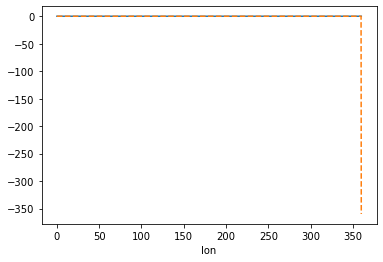

In [8]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

In [9]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 -19952250.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 -19952250.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 -1207965300.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarra

In [10]:
du_dx = grid.diff(ds_full.u.where(ds.u>-20), 'X') / ds_full.dxg
du_dx_ij = grid.interp(du_dx, 'X')
du_dx_ij

<xarray.DataArray 'mul-c98545041cd61d0be6ff2b3bcf33fa9f' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [11]:
du_dy = grid.diff(ds_full.u.where(ds.u>-20), 'Y') / ds_full.dyg
du_dy_ij = grid.interp(du_dy, 'Y')
du_dy_ij

<xarray.DataArray 'mul-0ff0d9cee8e5b79bfb66c365736c68ce' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [12]:
dv_dx = grid.diff(ds_full.v.where(ds.u>-20), 'X') / ds_full.dxg
dv_dx_ij = grid.interp(dv_dx, 'X')
dv_dx_ij

<xarray.DataArray 'mul-23c55358a718c1ec3c3bef70ae289ab1' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [13]:
dv_dy = grid.diff(ds_full.v.where(ds.u>-20), 'Y') / ds_full.dyg
dv_dy_ij = grid.interp(dv_dy, 'Y')
dv_dy_ij

<xarray.DataArray 'mul-6e807bfe98ae6a1f4126988a2e1cfc94' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

# 3. Save data 
#### i. nearest to the central mooring site, 
#### ii. interpolate into the central mooring site

In [35]:
du_dx_m = du_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
du_dy_m = du_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
dv_dx_m = dv_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
dv_dy_m = dv_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')

du_dx_m = np.real(du_dx_m).rename('du_dx_m')
du_dy_m = np.real(du_dy_m).rename('du_dy_m')
dv_dx_m = np.real(dv_dx_m).rename('dv_dx_m')
dv_dy_m = np.real(dv_dy_m).rename('dv_dy_m')

ddm = xr.merge([du_dx_m,du_dy_m,dv_dx_m,dv_dy_m])
ddm

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_ddm.nc'
%time ddm.to_netcdf(file_out, mode='w')     

In [15]:
u = ds.u.interp(lat=48.6875,lon=343.8125)
v = ds.v.interp(lat=48.6875,lon=343.8125)

du_dx_m = du_dx_ij.interp(lat=48.6875,lon=343.8125)
du_dy_m = du_dy_ij.interp(lat=48.6875,lon=343.8125)
dv_dx_m = dv_dx_ij.interp(lat=48.6875,lon=343.8125)
dv_dy_m = dv_dy_ij.interp(lat=48.6875,lon=343.8125)

du_dx_m = np.real(du_dx_m).rename('du_dx_m')
du_dy_m = np.real(du_dy_m).rename('du_dy_m')
dv_dx_m = np.real(dv_dx_m).rename('dv_dx_m')
dv_dy_m = np.real(dv_dy_m).rename('dv_dy_m')

ddm = xr.merge([u,v,du_dx_m,du_dy_m,dv_dx_m,dv_dy_m])
ddm

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_ddm_interp.nc'
%time ddm.to_netcdf(file_out, mode='w')   

CPU times: user 35.9 s, sys: 2.27 s, total: 38.2 s
Wall time: 57.9 s


## 4. Some figures 

## Results at the mooring site

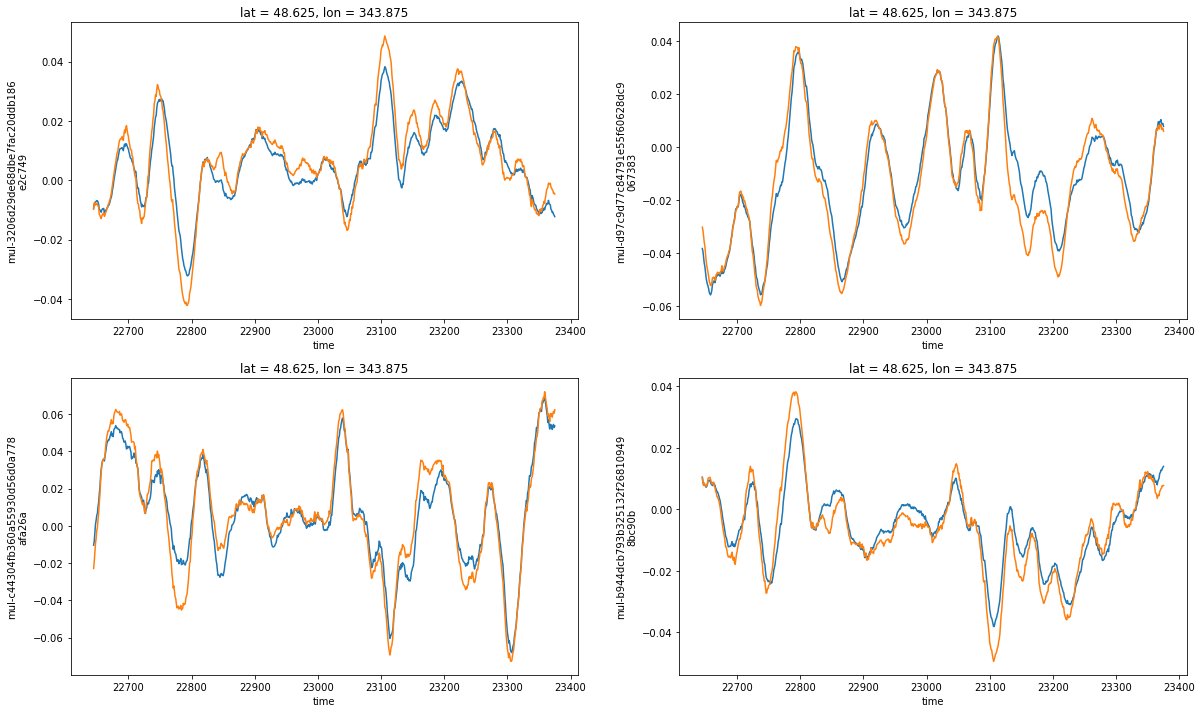

In [56]:
f_m = 2*omega*np.sin(np.deg2rad(48.6875))

fig = plt.figure(figsize=(20,12))

ax = plt.subplot(221)
(du_dx_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(du_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(222)
(du_dy_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(du_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(223)
(dv_dx_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(dv_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(224)
(dv_dy_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(dv_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

In [33]:
lon_grid, lat_grid = np.meshgrid(ds.lon, ds.lat)
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat_grid))
f

array([[-0.000146  , -0.000146  , -0.000146  , ..., -0.000146  ,
        -0.000146  , -0.000146  ],
       [-0.000146  , -0.000146  , -0.000146  , ..., -0.000146  ,
        -0.000146  , -0.000146  ],
       [-0.00014599, -0.00014599, -0.00014599, ..., -0.00014599,
        -0.00014599, -0.00014599],
       ...,
       [ 0.00014599,  0.00014599,  0.00014599, ...,  0.00014599,
         0.00014599,  0.00014599],
       [ 0.000146  ,  0.000146  ,  0.000146  , ...,  0.000146  ,
         0.000146  ,  0.000146  ],
       [ 0.000146  ,  0.000146  ,  0.000146  , ...,  0.000146  ,
         0.000146  ,  0.000146  ]], dtype=float32)

### divergence/f

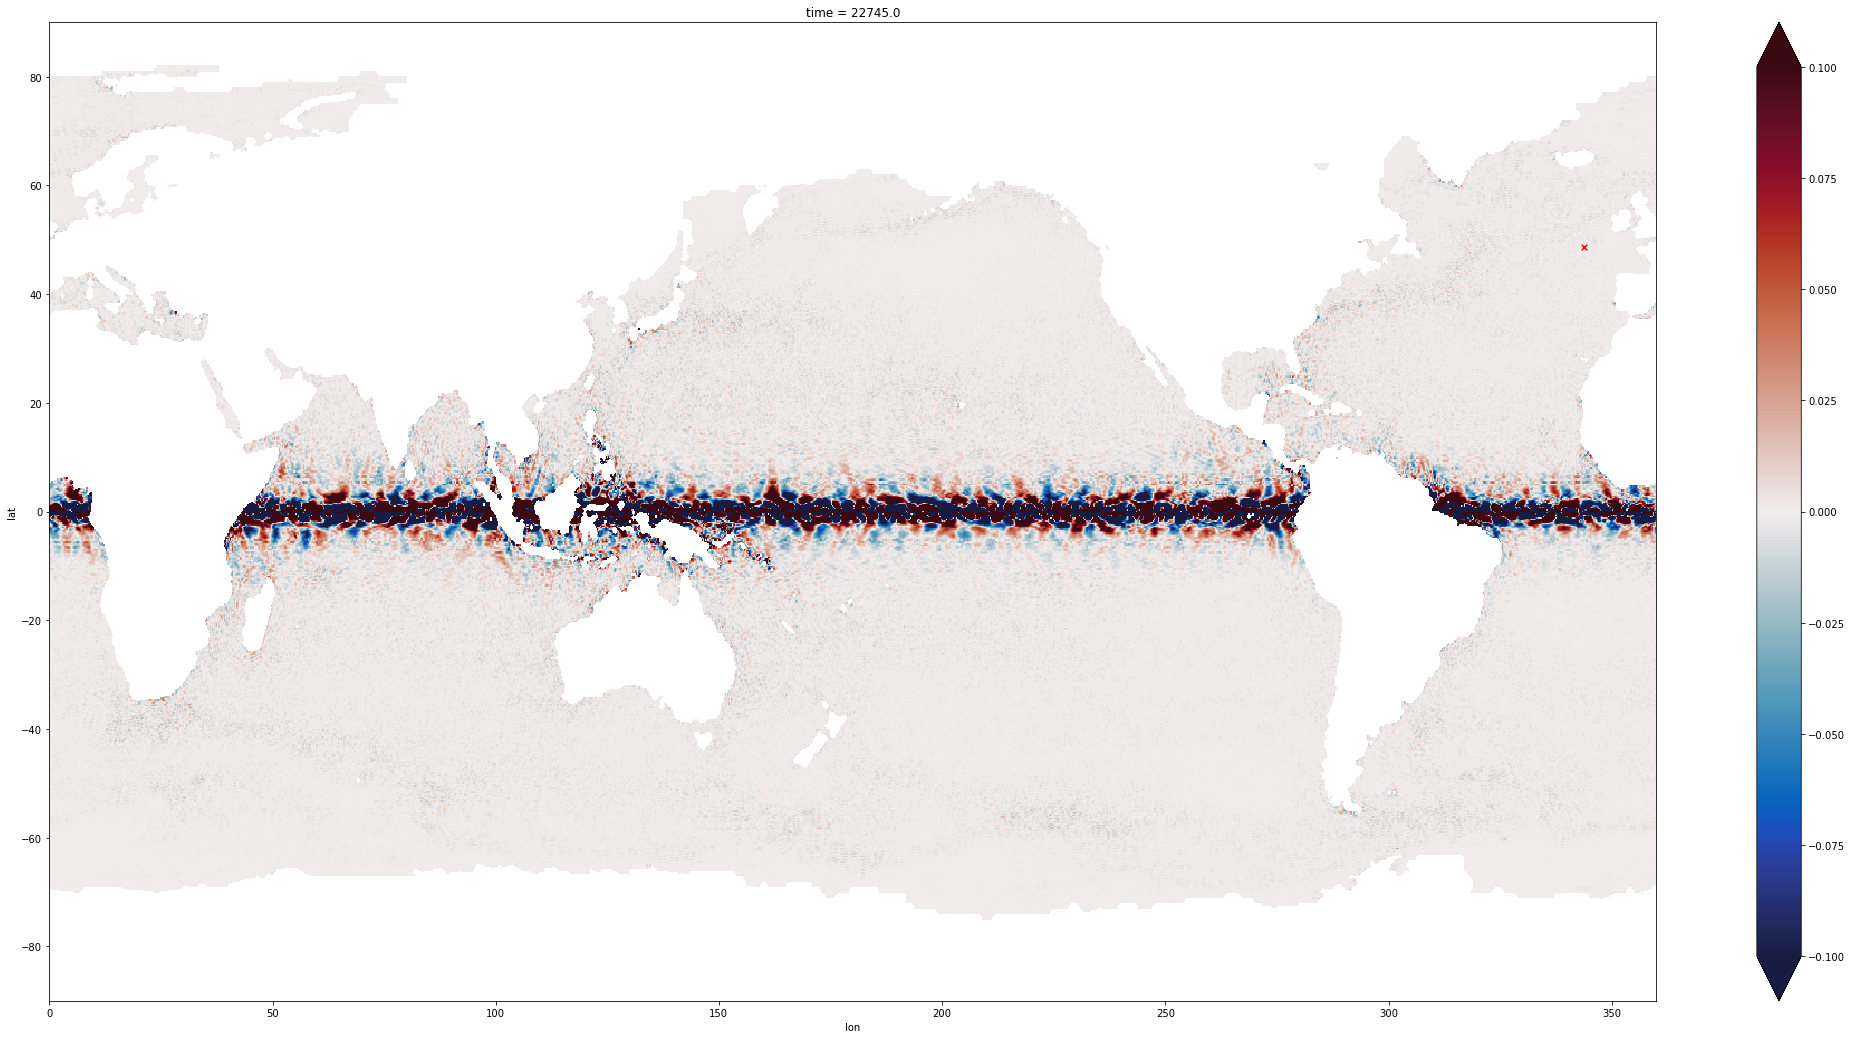

In [53]:
# divergence
fig = plt.figure(figsize=(36,18))
ax = plt.subplot(111)
((du_dx_ij+dv_dy_ij)/f).isel(time=100).plot(x='lon',y='lat',vmin=-.1,vmax=.1,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

### divergence

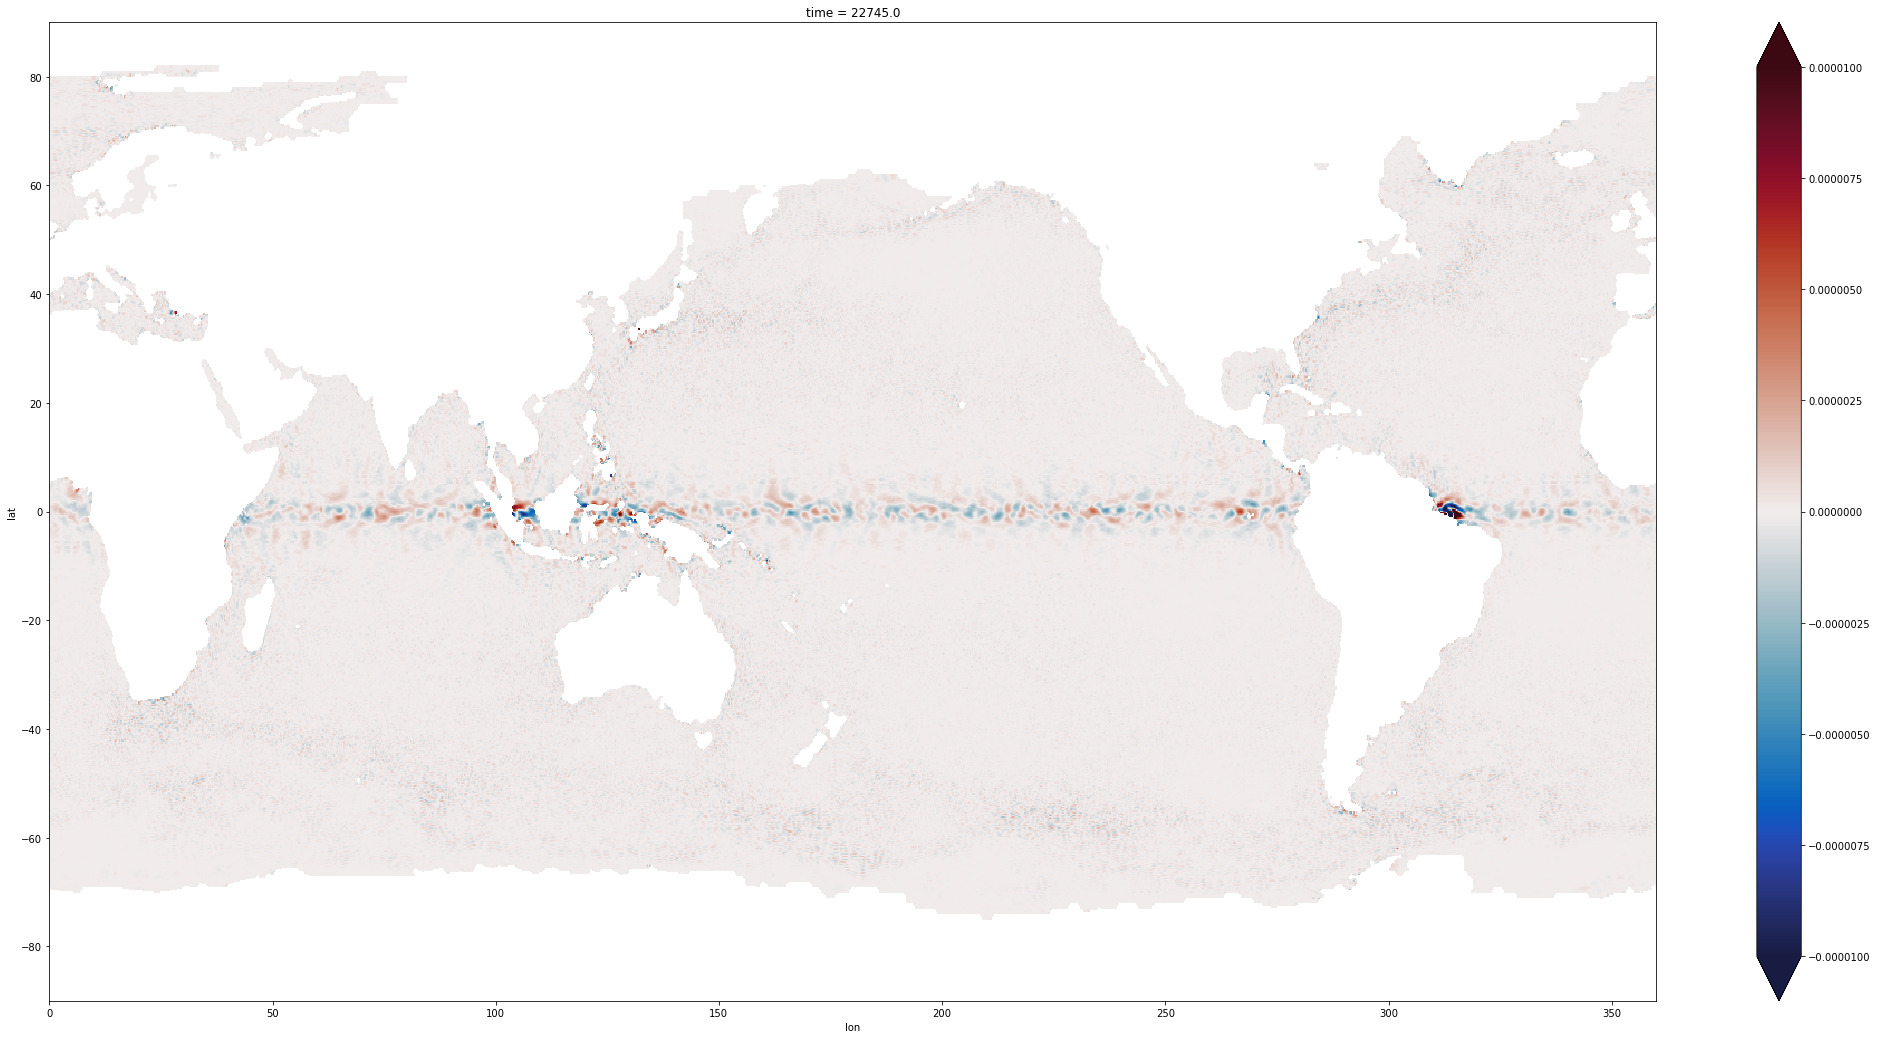

In [44]:
# divergence
fig = plt.figure(figsize=(36,18))
(du_dx_ij+dv_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.00001,vmax=0.00001,cmap=cm.balance)

### relative vorticity/f

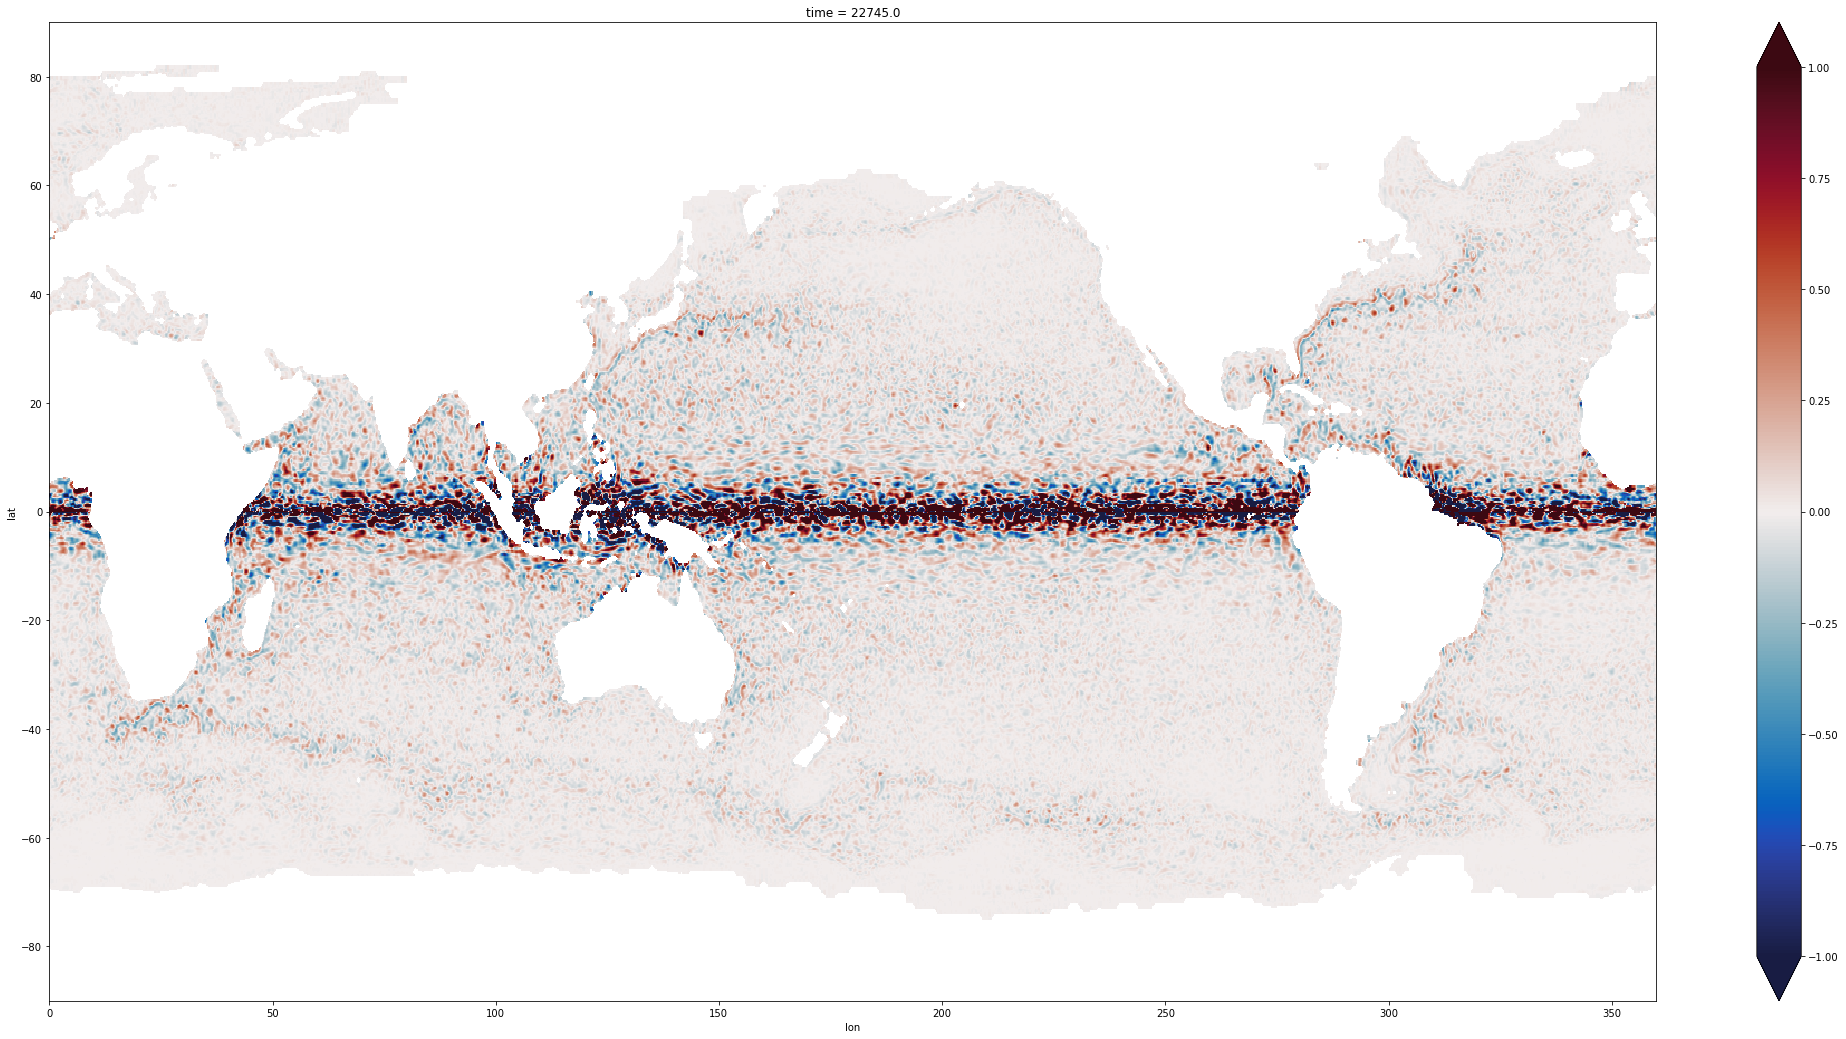

In [37]:
# relative vorticity/f
fig = plt.figure(figsize=(36,18))
((dv_dx_ij-du_dy_ij)/f).isel(time=100).plot(x='lon',y='lat',vmin=-1,vmax=1,cmap=cm.balance)

### relative vorticity

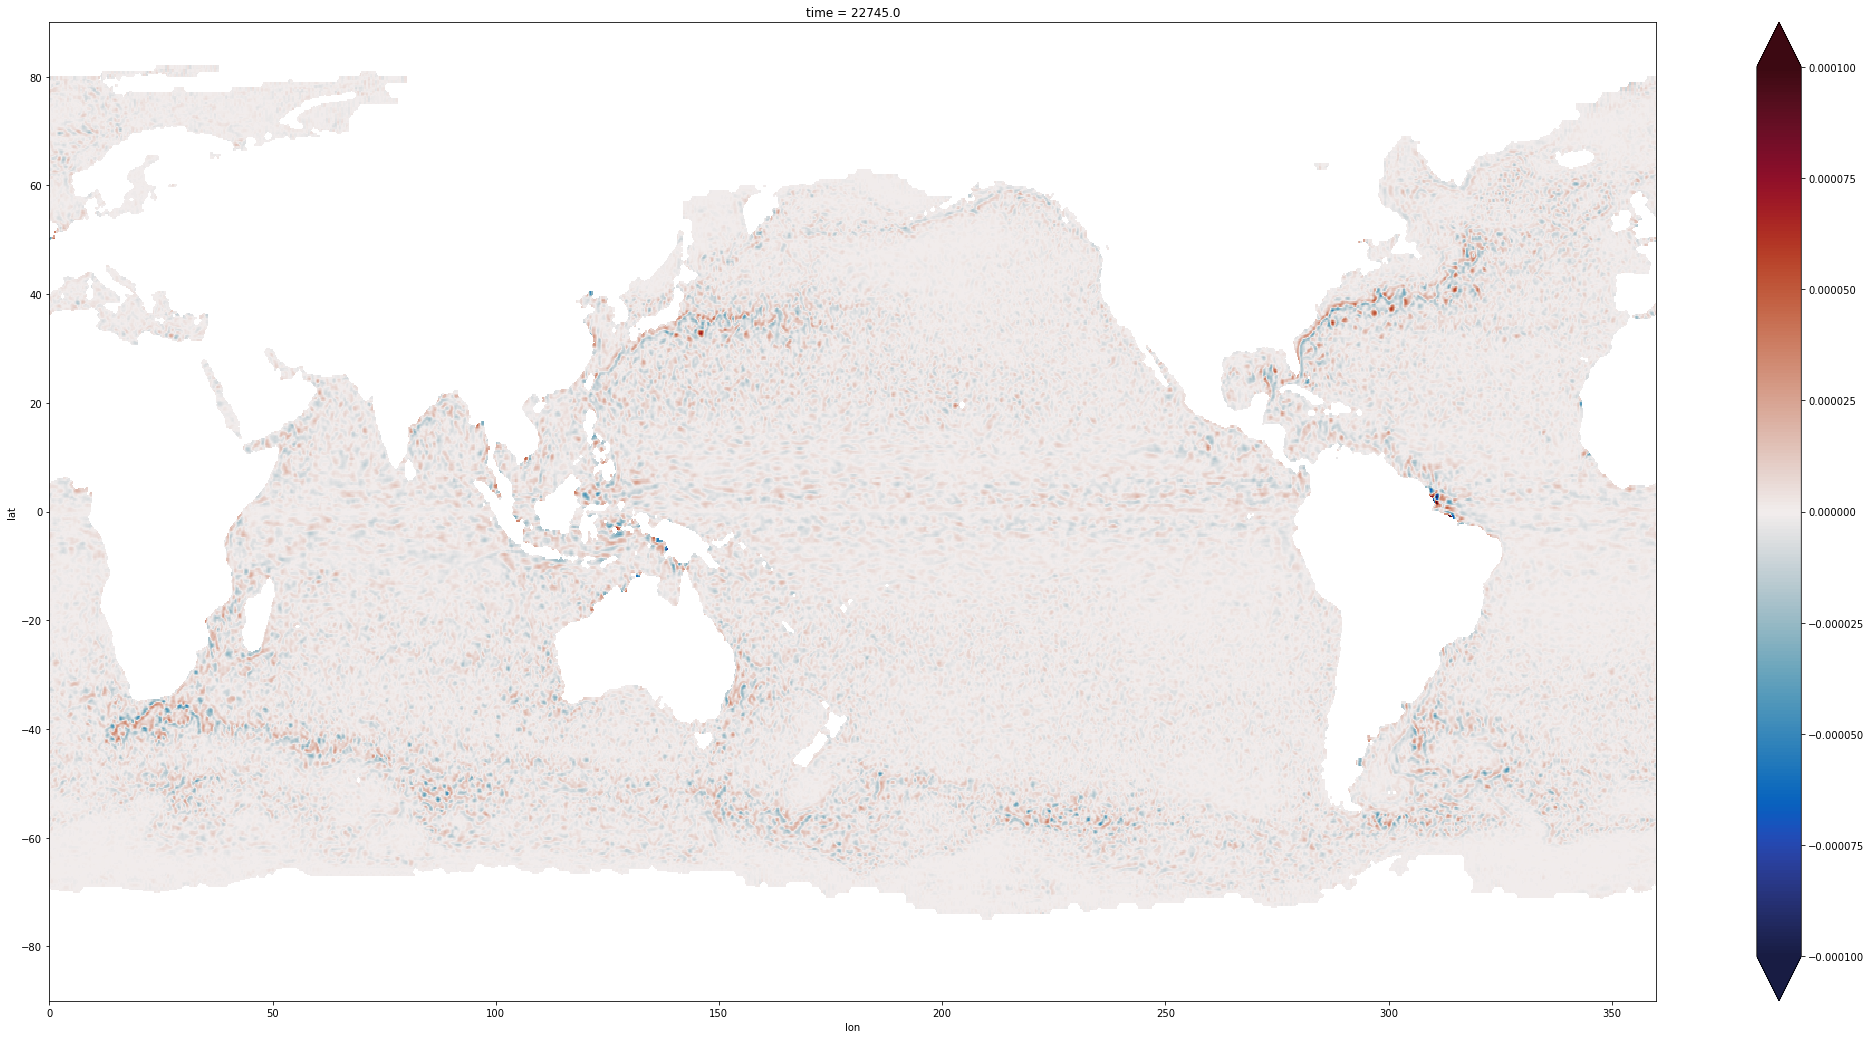

In [38]:
# relative vorticity
fig = plt.figure(figsize=(36,18))
(dv_dx_ij-du_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.0001,vmax=0.0001,cmap=cm.balance)

### KE

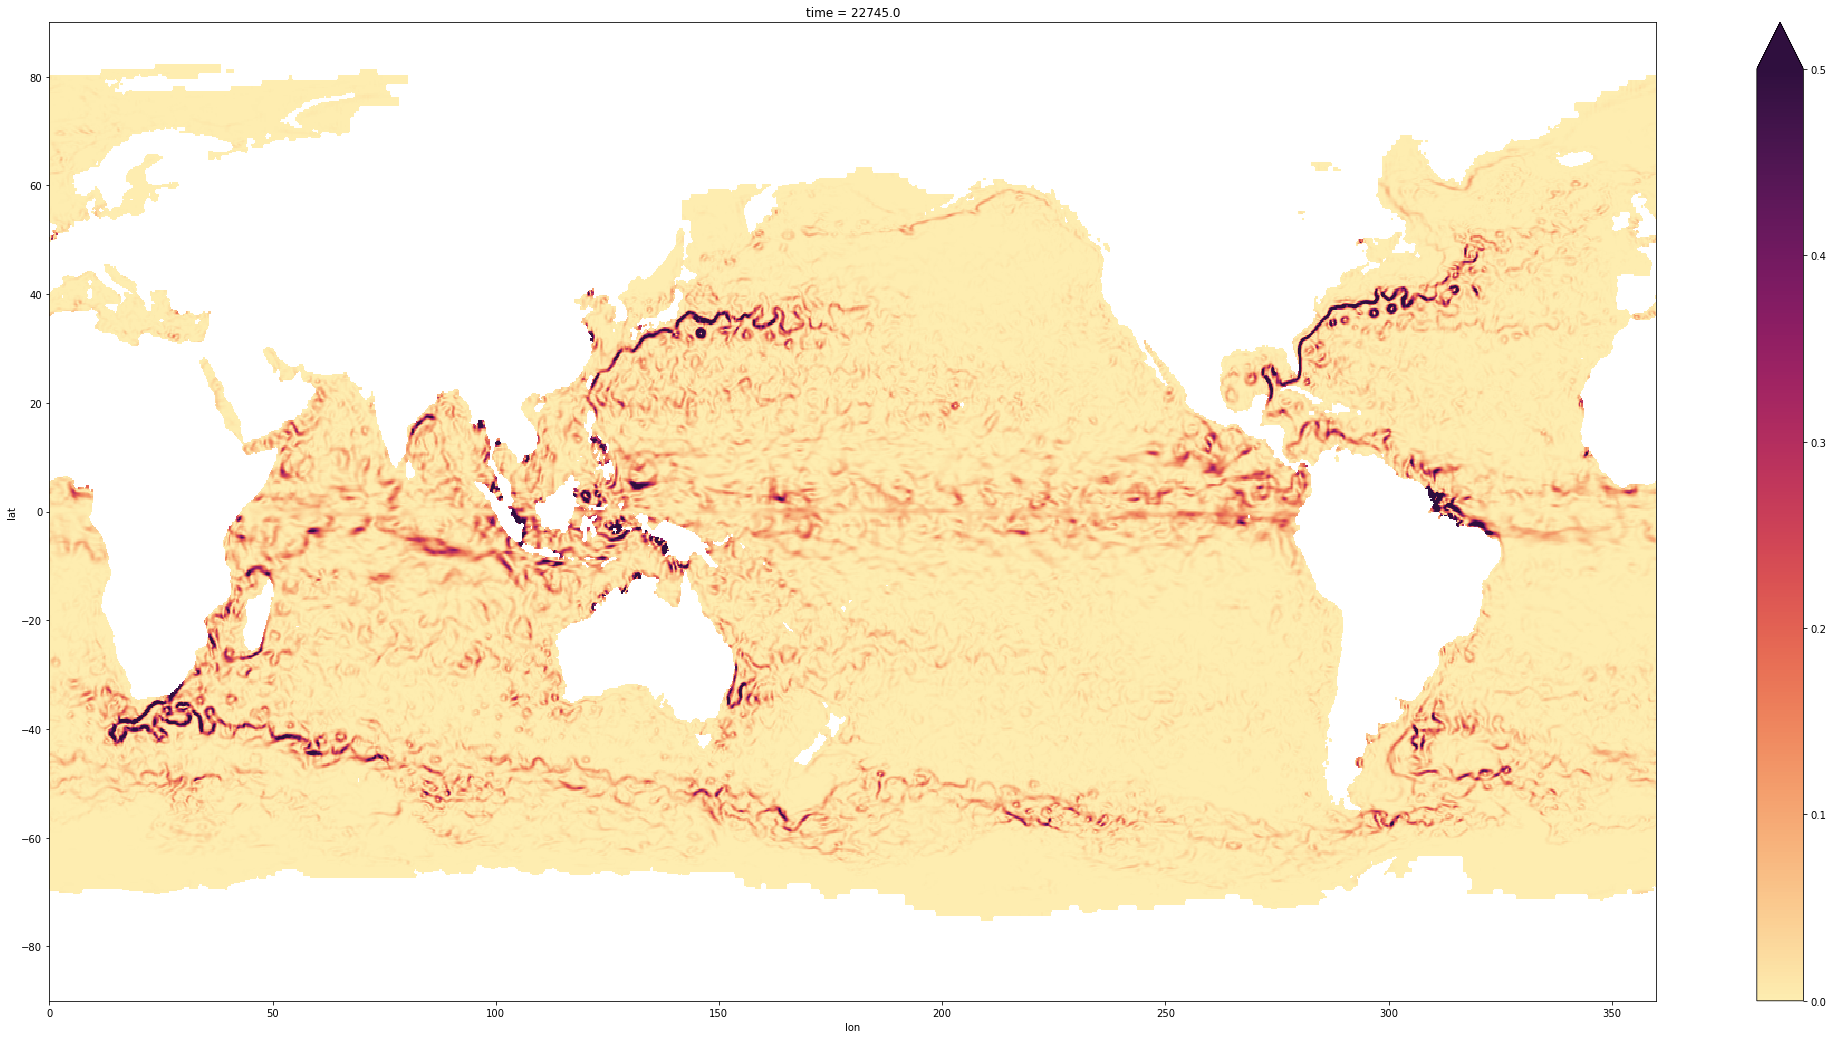

In [22]:
# KE
fig = plt.figure(figsize=(36,18))
(0.5*(ds.v.where(ds.v>-20)**2 + ds.u.where(ds.u>-20)**2)).isel(time=100).plot(x='lon',y='lat',vmin=0,vmax=0.5,cmap=cm.matter)

In [16]:
cluster.close()